In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision import datasets
import torch._dynamo
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


torch._dynamo.config.suppress_errors = True


# Check for CUDA and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
 
 
# Define the directory of my dataset
data_dir = "./DATA_LABELS"  # Modify with your correct path

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHS = 3
N_CLASSES = 3


# Define transformations
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),  # resize the images
    transforms.ToTensor(),# converting to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #normalization
])


#read image files directly and infer the label based on the filepath
class ProteinsDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = datasets.ImageFolder(data_dir, transform=transform)
       
    
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def classes(self):
        return self.data.classes
    
dataset=ProteinsDataset(data_dir, transform)

# Extract labels for stratified splitting
labels = np.array([dataset[i][1] for i in range(len(dataset))])  #(image, label) tuple

# Reserve 10% of the data as the test set
train_val_indices, test_indices, _, _ = train_test_split(
    np.arange(len(labels)),
    labels,
    test_size=0.1,
    stratify=labels,
    random_state=42
)

# Create 2 datasets
train_val_dataset = Subset(dataset, train_val_indices)
test_dataset = Subset(dataset, test_indices)


batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_N = len(test_loader.dataset)


#creating the neural network model
input_size =3* 128 * 128 # the input size (3 colour channels, 128 width,128 length)
n_classes = 3 # we need our output as 3 classes of proteins 
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, 1024),  # Input
    nn.LeakyReLU(negative_slope=0.01),# Activation for input
    
    
    nn.Linear(1024, 512),  # Hidden 1
    nn.LeakyReLU(negative_slope=0.01),  # Activation for hidden 
    nn.Dropout(p=0),  # Dropout after hidden layer 1
    
    nn.Linear(512, 512),  # Hidden 2
    nn.LeakyReLU(negative_slope=0.01),  # Activation for hidden
    
     
    nn.Linear(512, n_classes)  # Output
)

model = torch.compile(model.to(device)) # compiling the model and sending it to the GPU 
model #check the model layers 






def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

#augmentation
augment= transforms.Compose([
    transforms.RandomGrayscale(p=.1), #Converts the image to grayscale with a 20% probability
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.8, 1), ratio=(1, 1)), # resize the images
    transforms.RandomHorizontalFlip(),#flip images horizontally
    
])

# the training function

train_losses, train_accuracies = [], [] #creating two variables to store the accuracy and loss over the epoches 

def train(train_loader,train_N):
    loss = 0
    accuracy = 0

    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(augment(images))
        optimizer.zero_grad()
        batch_loss = loss_function(output, labels)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, labels, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
    train_loss = loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)

#validation function

valid_losses,valid_accuracies = [],[]#creating two variables to store the accuracy and loss over the epoches
def validate(valid_loader,valid_N):
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)

            loss += loss_function(output, labels).item()
            accuracy += get_batch_accuracy(output, labels, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))
    valid_loss = loss / len(valid_loader)
    valid_losses.append(valid_loss)
    valid_accuracies.append(accuracy)

#training loop


# Hyperparameters

k_folds = 5
# Define StratifiedKFold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Extract labels for stratified splitting
labelskf = np.array([sample[1] for sample in train_val_dataset])  # Assuming (data, label) structure in dataset

# StratifiedKFold splits
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labelskf)), labelskf)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Create subsets for train and validation
    train_subset = Subset(train_val_dataset, train_idx)
    valid_subset = Subset(train_val_dataset, val_idx)

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)

    # Get the number of batches
    train_N = len(train_loader)
    valid_N = len(valid_loader)
    
    # Initialize model, optimizer, and loss function
    loss_function = nn.CrossEntropyLoss() #loss_function provides a grade
    optimizer = Adam(model.parameters(), lr=0.001) # the optimizer tells the model how to learn from this grade to do better next time

    # Training epochs
    epochs = 30
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        
        #training function
        train(train_loader, train_N)
        
        # validation function
        validate(valid_loader, valid_N)
        
        

cuda
Fold 1/5

Epoch 1/30


c:\Users\Dana\Desktop\project\.venv\lib\site-packages\torch\_inductor\compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W1221 23:16:30.701950 5712 Lib\site-packages\torch\_dynamo\convert_frame.py:1125] WON'T CONVERT inner c:\Users\Dana\Desktop\project\.venv\lib\site-packages\torch\_dynamo\external_utils.py line 38 
W1221 23:16:30.701950 5712 Lib\site-packages\torch\_dynamo\convert_frame.py:1125] due to: 
W1221 23:16:30.701950 5712 Lib\site-packages\torch\_dynamo\convert_frame.py:1125] Traceback (most recent call last):
W1221 23:16:30.701950 5712 Lib\site-packages\torch\_dynamo\convert_frame.py:1125]   File "c:\Users\Dana\Desktop\project\.venv\lib\site-packages\torch\_dynamo\output_graph.py", line 1446, in _call_user_compiler
W1221 23:16:30.701950 5712 Lib\site-packages\torch\_dynamo\convert_frame.py:1125]     compil

Train - Loss: 221.1642 Accuracy: 20.0000
Valid - Loss: 10.1897 Accuracy: 18.4444

Epoch 2/30
Train - Loss: 35.6612 Accuracy: 27.4545
Valid - Loss: 9.2282 Accuracy: 20.4444

Epoch 3/30
Train - Loss: 32.6626 Accuracy: 31.8182
Valid - Loss: 8.2108 Accuracy: 27.5556

Epoch 4/30
Train - Loss: 30.0876 Accuracy: 35.0909
Valid - Loss: 7.6876 Accuracy: 32.4444

Epoch 5/30
Train - Loss: 29.4640 Accuracy: 35.7273
Valid - Loss: 7.7909 Accuracy: 30.8889

Epoch 6/30
Train - Loss: 30.7961 Accuracy: 33.7576
Valid - Loss: 7.6807 Accuracy: 29.0000

Epoch 7/30
Train - Loss: 27.7096 Accuracy: 37.2121
Valid - Loss: 7.2459 Accuracy: 34.8889

Epoch 8/30
Train - Loss: 26.2380 Accuracy: 39.9091
Valid - Loss: 7.1979 Accuracy: 33.1111

Epoch 9/30
Train - Loss: 24.3899 Accuracy: 41.5758
Valid - Loss: 7.1558 Accuracy: 34.7778

Epoch 10/30
Train - Loss: 25.8608 Accuracy: 40.0909
Valid - Loss: 6.8335 Accuracy: 36.3333

Epoch 11/30
Train - Loss: 25.7039 Accuracy: 41.3030
Valid - Loss: 6.3041 Accuracy: 40.2222

Epoch 

Visualize Losses

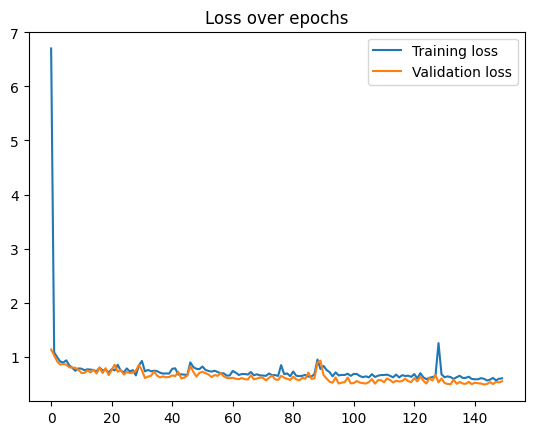

In [2]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

Visualize Losses

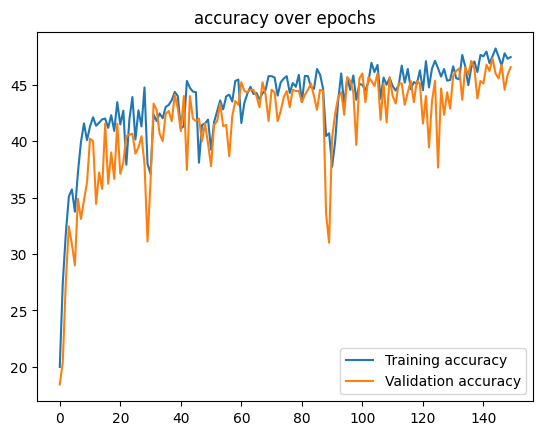

In [3]:
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(valid_accuracies, label='Validation accuracy')
plt.legend()
plt.title("accuracy over epochs")
plt.show()

evaluation function 

In [4]:
from torchvision.datasets import ImageFolder
class_names=ImageFolder(data_dir).classes#getting the classes names

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.81      0.74       100
           1       0.69      0.64      0.67        92
           2       0.83      0.72      0.77       100

    accuracy                           0.73       292
   macro avg       0.73      0.72      0.72       292
weighted avg       0.73      0.73      0.73       292

Confusion Matrix:
[[81 16  3]
 [21 59 12]
 [18 10 72]]
accuracy score: 0.726027397260274
area under the curve: 0.8851343599033816


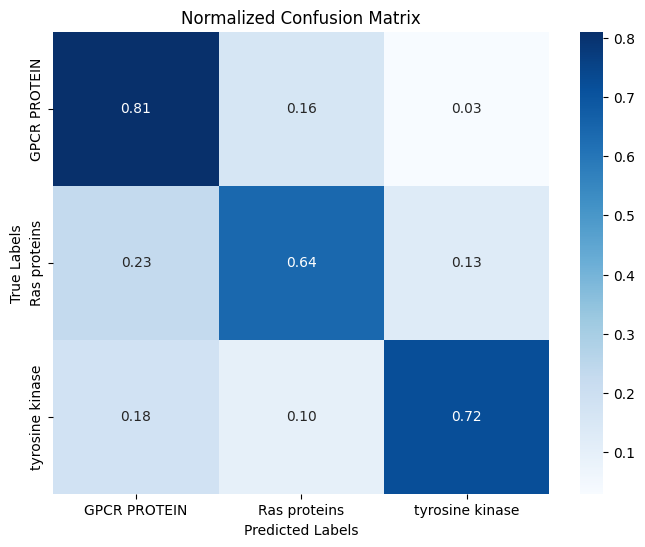

In [5]:
import torch.nn.functional as F
import seaborn as sns
y_true = []
y_pred = []
y_prob=[]
def evaluate():
    
    model.eval()  #Puts the model in evaluation mode.
    

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device) 
            labels =labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            # Apply softmax to get probabilities
            probabilities = F.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(probabilities.cpu().numpy())  # Predicted probabilities

    print("Classification Report:")
    print(classification_report(y_true, y_pred)) #provides precision, recall, F1-score, and accuracy for each class.

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred)) # visualizes the performance of the classification
    
    
evaluate()
from sklearn.metrics import accuracy_score, roc_auc_score

auc = accuracy_score(y_true, y_pred) #get the accuracy score
print("accuracy score:", auc)
auc = roc_auc_score(y_true, y_prob, multi_class="ovr")#get the area under curve
print("area under the curve:", auc)


#define plot function for the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
 
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", 
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
#getting the classes names
plot_confusion_matrix(y_true, y_pred, class_names) #plotting the matrix